In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sph_harm, lpmv
from scipy.integrate import solve_ivp

C:\Users\Seiven\AppData\Local\Temp\ipykernel_27464\4205484964.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  y0[idx] = project_initial_condition(l, m, sigma)


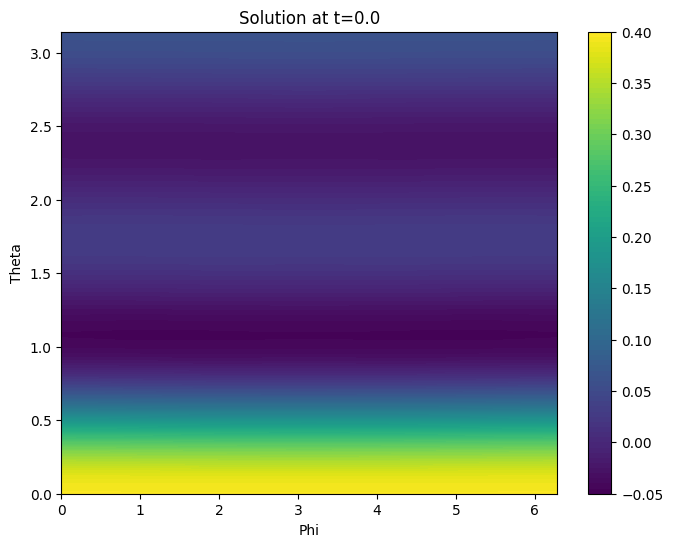

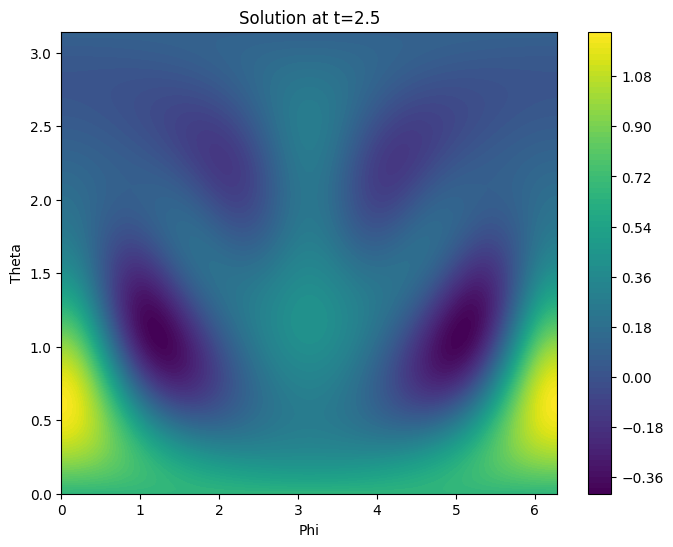

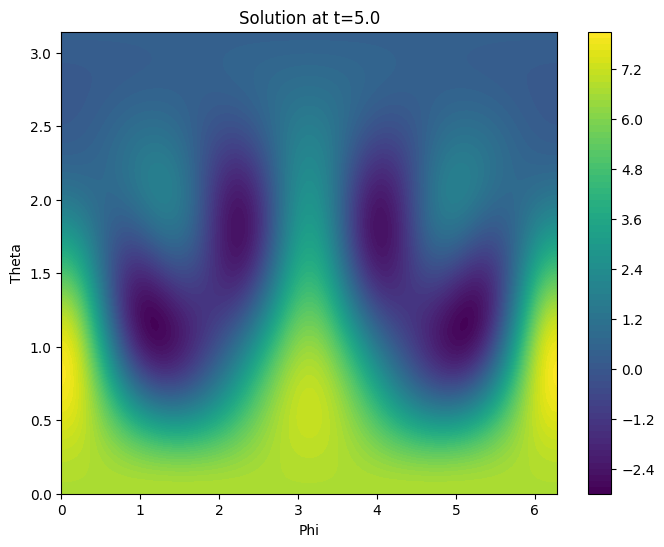

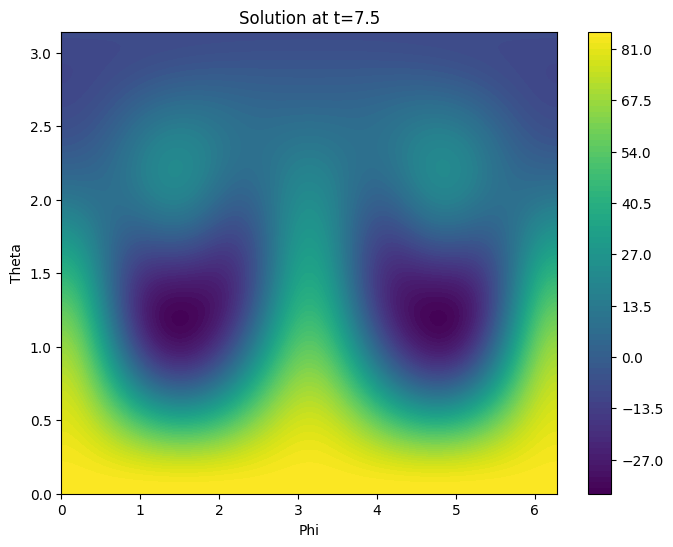

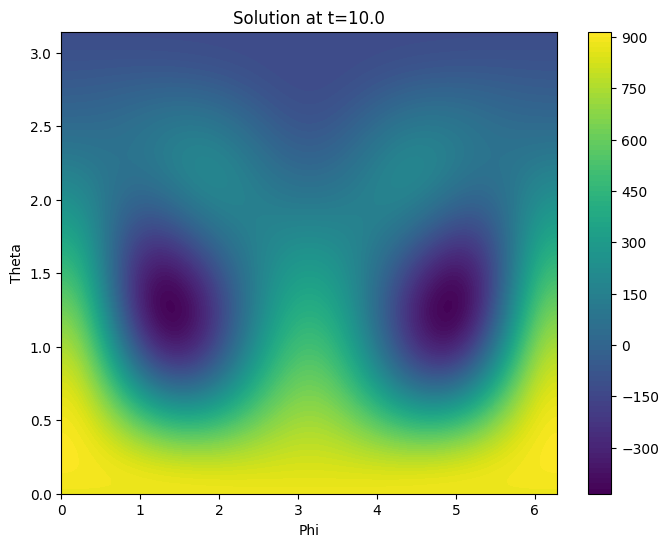

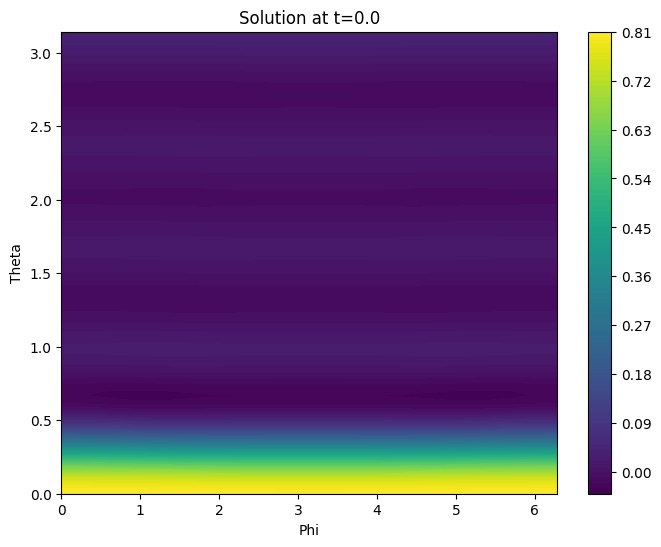

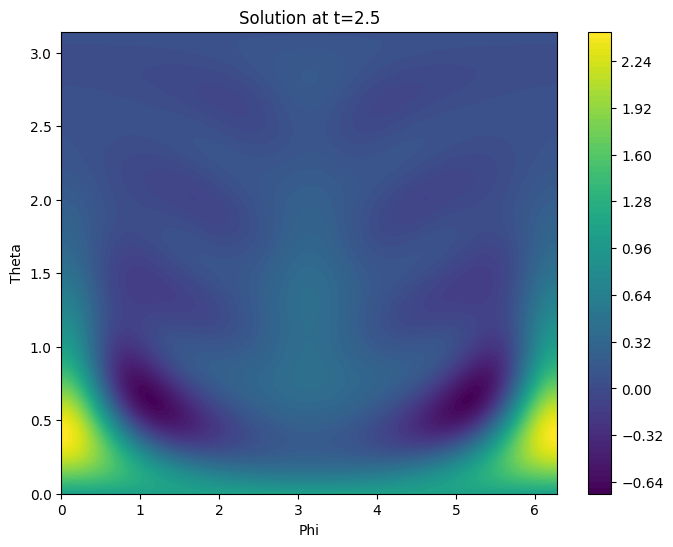

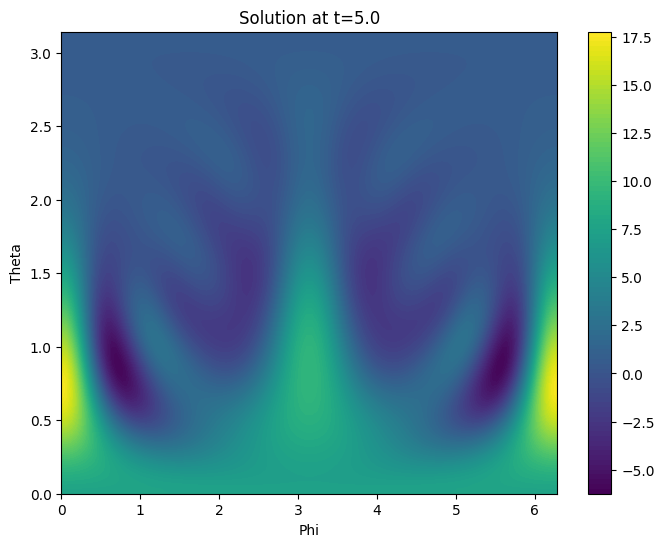

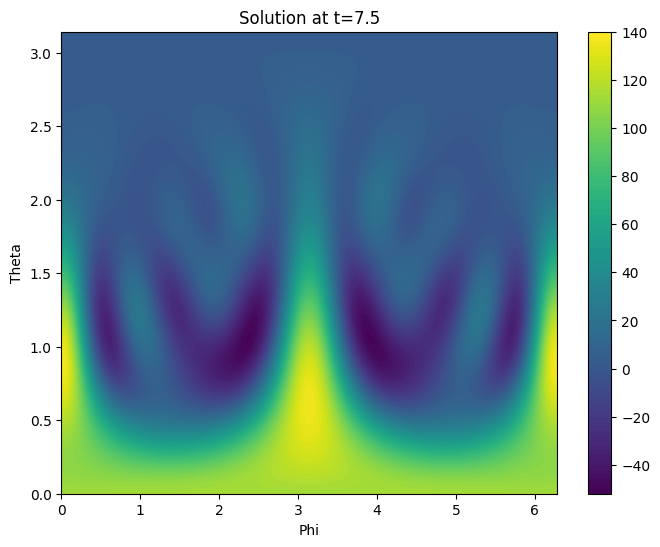

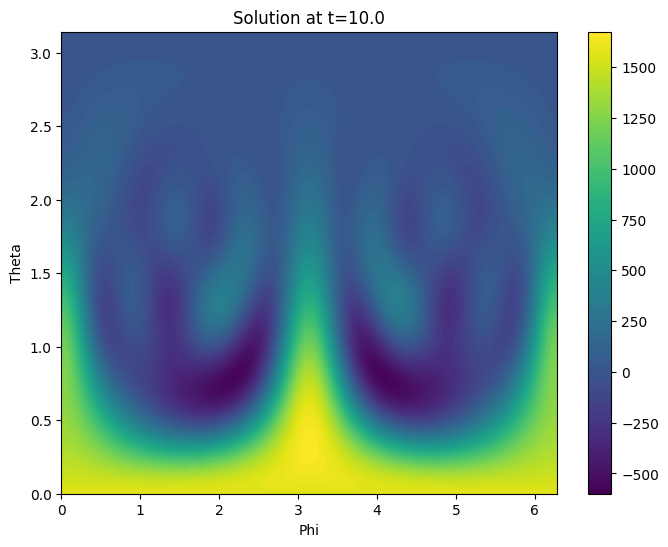

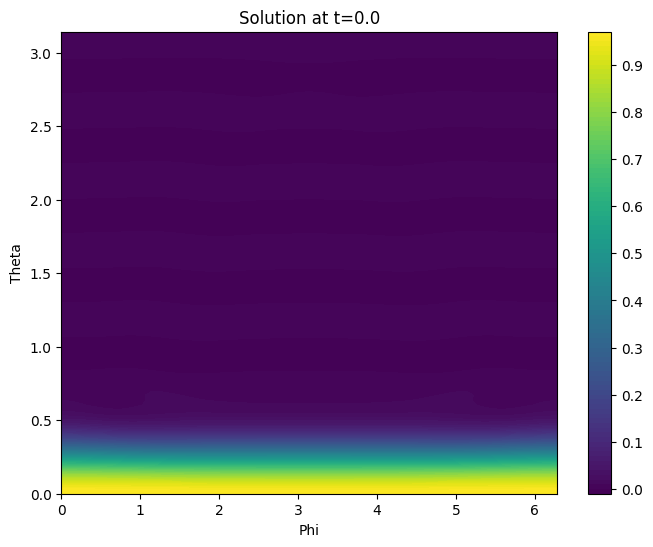

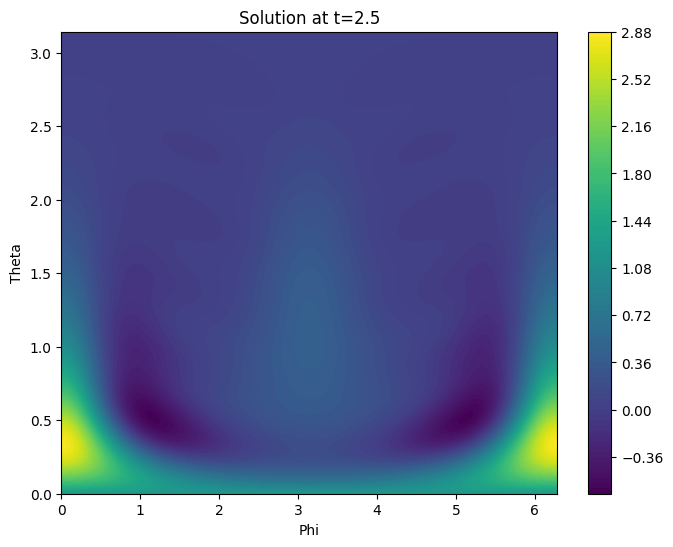

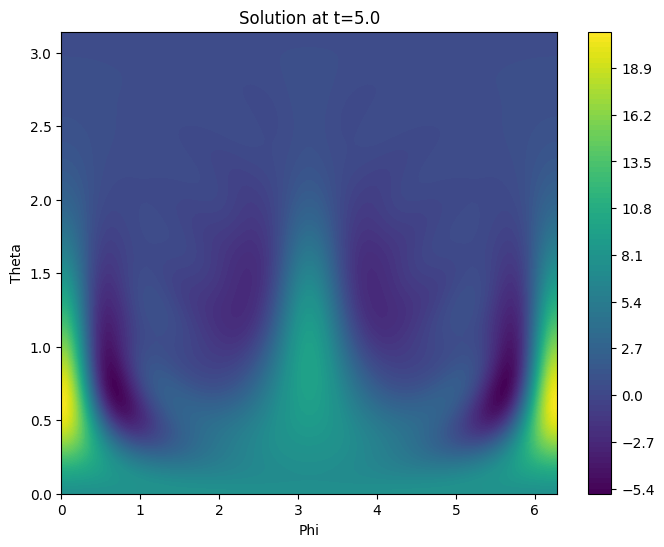

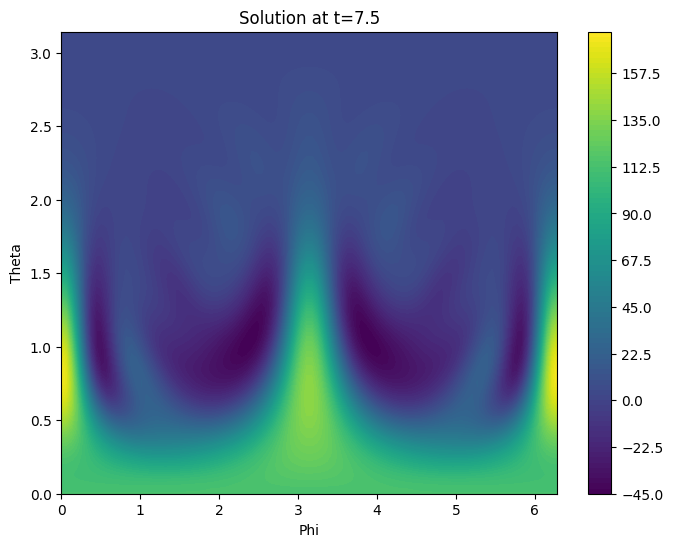

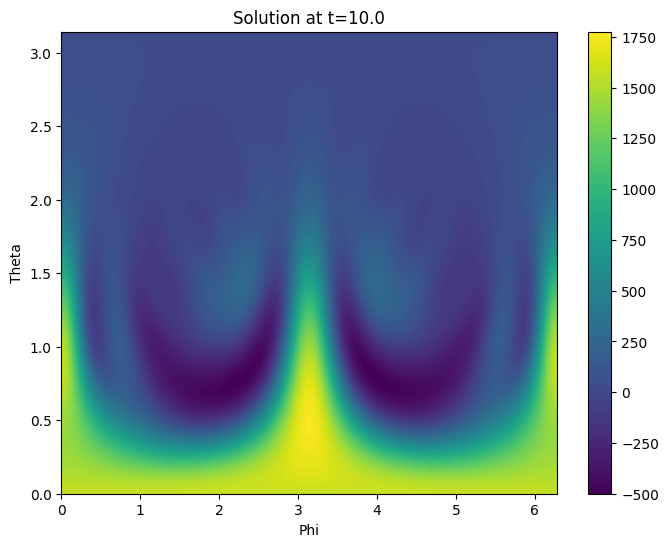

In [2]:
# Parameters
l_max = 4  # Maximum degree of spherical harmonics
sigma = 0.2  # Width of the initial condition
t_max = 10  # Maximum time
n_points = 100  # Number of points for theta and phi

# Define theta and phi arrays
theta = np.linspace(0, np.pi, n_points)
phi = np.linspace(0, 2 * np.pi, n_points)
Theta, Phi = np.meshgrid(theta, phi)


# Initial condition function
def initial_condition(theta, sigma):
    return np.exp(-(theta**2) / (2 * sigma**2))


# Project initial condition onto spherical harmonics basis
def project_initial_condition(l, m, sigma):
    integral = 0
    for i, theta_val in enumerate(theta):
        for j, phi_val in enumerate(phi):
            Y_lm = np.conj(sph_harm(m, l, phi_val, theta_val))
            integral += initial_condition(theta_val, sigma) * Y_lm * np.sin(theta_val)
    return integral * (theta[1] - theta[0]) * (phi[1] - phi[0])


# ODE system for c_lm(t) and psi_lm(t)
def ode_system(t, y, l_max):
    dydt = np.zeros_like(y)
    for l in range(l_max + 1):
        for m in range(-l, l + 1):
            idx = l**2 + l + m
            dydt[idx] = y[idx + 1]  # d/dt c_lm(t) = psi_lm(t)
            dydt[idx + 1] = -l * (l + 1) * y[idx]  # d/dt psi_lm(t) = -l(l+1)c_lm(t)
    return dydt


# Solve the ODE system
def solve_ode(l_max, sigma, t_max):
    # Number of coefficients
    n_coeffs = (l_max + 1) ** 2
    # Initial conditions for c_lm(0) and psi_lm(0)
    y0 = np.zeros(2 * n_coeffs)
    for l in range(l_max + 1):
        for m in range(-l, l + 1):
            idx = l**2 + l + m
            y0[idx] = project_initial_condition(l, m, sigma)
    # Time span
    t_span = [0, t_max]
    # Solve ODE
    sol = solve_ivp(ode_system, t_span, y0, args=(l_max,), dense_output=True)
    return sol


# Visualization of the solution at a given time t
def visualize_solution(sol, t, l_max, theta, phi):
    phi_vals, theta_vals = np.meshgrid(phi, theta)
    phi_plot = np.linspace(0, 2 * np.pi, n_points)
    theta_plot = np.linspace(0, np.pi, n_points)
    Phi_plot, Theta_plot = np.meshgrid(phi_plot, theta_plot)
    Z = np.zeros_like(Phi_plot)
    for l in range(l_max + 1):
        for m in range(-l, l + 1):
            idx = l**2 + l + m
            c_lm = sol.sol(t)[idx]
            Z += c_lm * sph_harm(m, l, Phi_plot, Theta_plot).real
    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(Phi_plot, Theta_plot, Z, 100, cmap="viridis")
    plt.colorbar()
    plt.title(f"Solution at t={t}")
    plt.xlabel("Phi")
    plt.ylabel("Theta")
    plt.show()


# Main execution
if __name__ == "__main__":
    l_max_values = [4, 8, 12]  # Different l_max values for comparison
    for l_max in l_max_values:
        sol = solve_ode(l_max, sigma, t_max)
        # Visualize at different time steps
        for t in np.linspace(0, t_max, 5):
            visualize_solution(sol, t, l_max, theta, phi)